# library

In [ ]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pydicom
import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping

# import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# fichier csv
csv_path = '/content/drive/MyDrive/Master_2/defi_3/trainSet-rle.csv'

In [ ]:
# dossier dcm
folder_path = '/content/drive/MyDrive/Master_2/defi_3/dicom-images-train'

In [ ]:
# Vérification
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
print(f"Le dossier '{folder_path}' contient {file_count} fichiers.")

Le dossier '/content/drive/MyDrive/Master_2/defi_3/dicom-images-train' contient 9494 fichiers.


# crée le dossier "sample"   - 12mn

In [ ]:
# Chemin vers le dossier source
source_folder = '/content/drive/MyDrive/Master_2/defi_3/dicom-images-train'

# Chemin vers le nouveau dossier
destination_folder = '/content/sample'

# Créer le dossier de destination
os.makedirs(destination_folder, exist_ok=True)

# Obtenir la liste des fichiers dans le dossier source
files = sorted(os.listdir(source_folder))[:200]

# Copier les fichiers vers le dossier destination
for file_name in files:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    shutil.copy(source_file, destination_file)

# Vérification
file_count = len([f for f in os.listdir('/content/sample') if os.path.isfile(os.path.join('/content/sample', f))])
print(f"Le dossier '{'/content/sample'}' contient {file_count} fichiers.")

Le dossier '/content/sample' contient 200 fichiers.


# différente taille

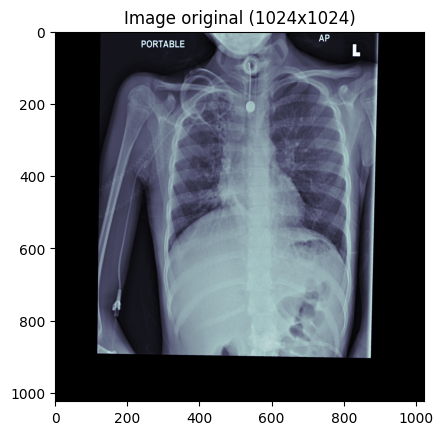

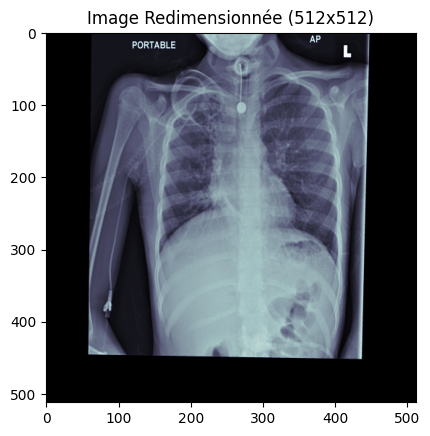

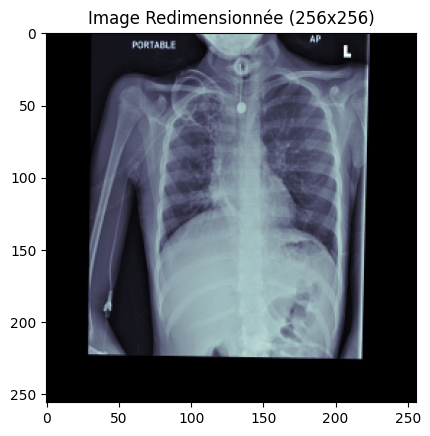

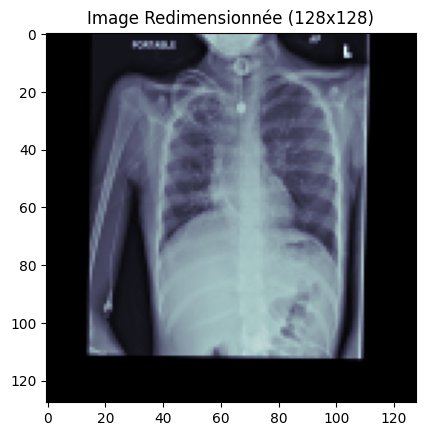

In [ ]:
ds = pydicom.dcmread('/content/drive/MyDrive/Master_2/defi_3/dicom-images-train/1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.dcm')
image = ds.pixel_array

plt.imshow(image, cmap=plt.cm.bone)
plt.title("Image original (1024x1024)")
plt.show()

image_resized_512 = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
plt.imshow(image_resized_512, cmap=plt.cm.bone)
plt.title("Image Redimensionnée (512x512)")
plt.show()

image_resized_256 = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
plt.imshow(image_resized_256, cmap=plt.cm.bone)
plt.title("Image Redimensionnée (256x256)")
plt.show()

image_resized_128 = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
plt.imshow(image_resized_128, cmap=plt.cm.bone)
plt.title("Image Redimensionnée (128x128)")
plt.show()

# Préparation Model_1

In [ ]:
# fichier csv
data = pd.read_csv(csv_path, sep=';')

# Créer une colonne 'Label' : 0 pour EncodedPixels = -1, 1 sinon
data['Label'] = data['EncodedPixels'].apply(lambda x: 0 if x == '-1' else 1)

# Supprimer les doublons basés sur la colonne ImageId
data = data.drop_duplicates(subset="ImageId", keep="first")

In [ ]:
data.shape

(9676, 3)

In [ ]:
# Fonction pour charger et prétraiter les images DICOM
def preprocess_dicom_image(file_path, img_size=(256, 256)):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array
    img = img / np.max(img)  # Normaliser entre 0 et 1
    img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    return img_resized

In [ ]:
# Chemins vers le dossier DICOM
dcm_folder = folder_path

# Fonction pour charger et prétraiter les images DICOM
def preprocess_dicom_image(file_path, img_size=(256, 256)):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array
    img = img / np.max(img)  # Normaliser entre 0 et 1
    img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    return img_resized

# X et y
X = []
y = []

# Préparer les données avec une barre de progression
for _, row in tqdm(data.iterrows(), total=len(data), desc="Préparation des données"):
    image_id = row["ImageId"]
    label = row["Label"]
    dcm_path = os.path.join(dcm_folder, f"{image_id}.dcm")

    if os.path.exists(dcm_path):  # Vérifier si le fichier existe
        preprocessed_image = preprocess_dicom_image(dcm_path)
        X.append(preprocessed_image)
        y.append(label)

Préparation des données:   0%|          | 10/9676 [00:03<50:12,  3.21it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-24e89ae932d6>", line 23, in <cell line: 17>
    preprocessed_image = preprocess_dicom_image(dcm_path)
  File "<ipython-input-11-24e89ae932d6>", line 6, in preprocess_dicom_image
    dicom = pydicom.dcmread(file_path)
  File "/usr/local/lib/python3.10/dist-packages/pydicom/filereader.py", line 1078, in dcmread
    dataset = read_partial(
  File "/usr/local/lib/python3.10/dist-packages/pydicom/filereader.py", line 839, in read_partial
    preamble = read_preamble(fileobj, force)
  File "/usr/local/lib/python3.10/dist-packages/pydicom/filereader.py", line 766, in read_preamble
    preamble = fp.read(128)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Convertir en tableaux numpy
X = np.array(X, dtype="float32")
y = np.array(y, dtype="int")

# Ajouter une dimension de canal
X = np.expand_dims(X, axis=-1)

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des dimensions
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Modèle

In [ ]:
# Définir le modèle CNN
model_1 = tf.keras.Sequential([
    # Couche convolutive 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Couche convolutive 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Couche convolutive 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Aplatir pour connecter aux couches fully connected
    tf.keras.layers.Flatten(),

    # Couche dense
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout pour éviter le surapprentissage

    # Couche de sortie
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid pour classification binaire
])

# Compiler le modèle
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model_1.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))

NameError: name 'tf' is not defined

In [ ]:
# Sauvegarder le modèle
model_1.save('model_1.h5')

NameError: name 'model_1' is not defined

# Evaluation_1

In [ ]:
# Prédictions sur les données de test
y_pred_proba = model_1.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")
print("\nMatrice de confusion :\n", conf_matrix)
print("\nClassification Report :\n", class_report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step
Accuracy : 0.72
Precision: 0.00
Recall   : 0.00
F1 Score : 0.00

Matrice de confusion :
 [[29  0]
 [11  0]]

Classification Report :
               precision    recall  f1-score   support

           0       0.72      1.00      0.84        29
           1       0.00      0.00      0.00        11

    accuracy                           0.72        40
   macro avg       0.36      0.50      0.42        40
weighted avg       0.53      0.72      0.61        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

# courbe ROC

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 904ms/step


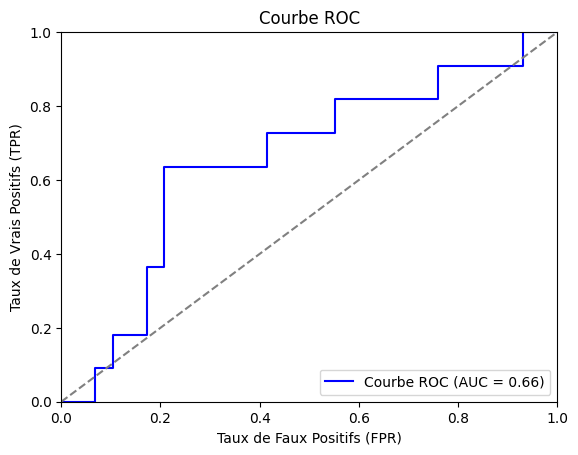

In [ ]:
y_pred_proba = model_1.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()